# CRS Configuration Statistical Analysis

This notebook provides comprehensive statistical analysis of ModSecurity/CRS configurations.

## Analysis Dimensions
- **Paranoia Level**: How config behavior changes with PL 1-4
- **Attack Types**: Distribution by type (SQL injection, XSS, RCE, etc.)
- **Anomaly Score**: Threshold impact analysis
- **Rule Location**: CRS core vs custom vs app-specific
- **Processing Phase**: Distribution by execution phase (1-5)
- **Severity**: CRITICAL, ERROR, WARNING, NOTICE distribution

## 1. Setup and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Import the analyzer module
from crs_analyzer import (
    CRSAnalyzer,
    CRSVisualizationHelper as viz,
    ATTACK_TYPE_LABELS,
    PHASE_NAMES,
)

# Set visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Setup complete!")

Setup complete!


## 2. Load Configuration

In [2]:
# Path to the main CRS setup file
CONFIG_PATH = "config/modsecurity/setup.conf"

# Load configuration
analyzer = CRSAnalyzer()
analyzer.load(CONFIG_PATH)

# Display basic info
summary = analyzer.summary()
display(Markdown("## Configuration Summary"))
print(f"Configuration loaded: {CONFIG_PATH}")
print(f"Total files parsed: {summary['total_files']}")
print(f"Total rules: {summary['total_rules']}")
print(f"  - SecRule: {summary['rules_by_type']['SecRule']}")
print(f"  - SecAction: {summary['rules_by_type']['SecAction']}")
print(f"Unique attack types: {summary['unique_attack_types']}")

## Configuration Summary

Configuration loaded: config/modsecurity/setup.conf
Total files parsed: 40
Total rules: 829
  - SecRule: 816
  - SecAction: 13
Unique attack types: 18


## 3. Paranoia Level Analysis

CRS Paranoia Levels control detection sensitivity:
- **PL1**: Default, most core rules. Low false positives.
- **PL2**: Extra rules, more regexp-based protections.
- **PL3**: More rules, stricter limits.
- **PL4**: Highest sensitivity, may have many false positives.

In [3]:
# Get paranoia level statistics
pl_stats = analyzer.paranoia.get_stats_per_level()

# Display comparison table
display(Markdown("### Paranoia Level Comparison Table"))
df_pl = analyzer.paranoia.get_comparison_dataframe()
display(df_pl.style.background_gradient(cmap='YlOrRd', subset=['Cumulative Rules']))

### Paranoia Level Comparison Table

,Paranoia Level,New Rules,Cumulative Rules,CRITICAL,ERROR,WARNING,NOTICE
0,1,175,175,137,11,12,13
1,2,52,227,42,1,5,3
2,3,19,246,16,0,3,0
3,4,7,253,4,0,3,0


### Rules per Paranoia Level

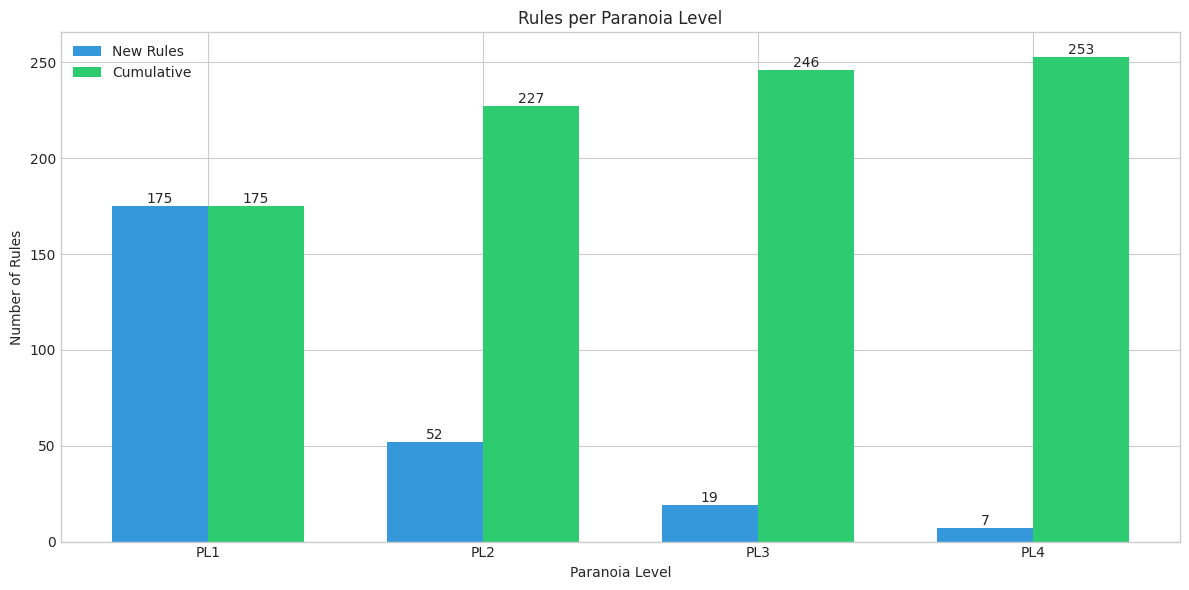

In [4]:
# Visualize paranoia level comparison
display(Markdown("### Rules per Paranoia Level"))
fig = viz.plot_paranoia_comparison(pl_stats)
plt.show()

### Severity Distribution by Paranoia Level

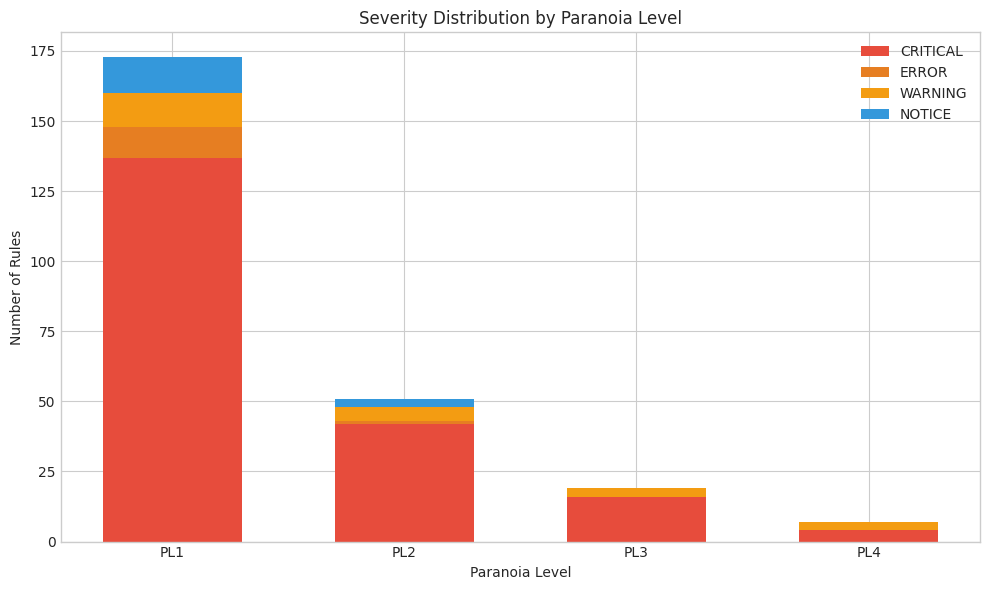

In [5]:
# Severity distribution by paranoia level
display(Markdown("### Severity Distribution by Paranoia Level"))
fig = viz.plot_paranoia_stacked_severity(pl_stats)
plt.show()

## 4. Coverage Delta Analysis

What changes when moving between paranoia levels?

In [6]:
# Delta: PL1 -> PL2
display(Markdown("### Coverage Delta: PL1 -> PL2"))
delta_1_2 = analyzer.paranoia.get_coverage_delta(1, 2)
print(f"New rules added: {delta_1_2['new_rules_count']}")
print(f"New attack types covered: {delta_1_2['new_attack_types']}")
print(f"Severity breakdown of new rules: {delta_1_2['severity_breakdown']}")

### Coverage Delta: PL1 -> PL2

New rules added: 52
New attack types covered: ['reputation-crawler', 'reputation-scripting']
Severity breakdown of new rules: {'NOTICE': 3, 'CRITICAL': 42, 'WARNING': 5, 'ERROR': 1}


In [7]:
# Delta: PL2 -> PL3
display(Markdown("### Coverage Delta: PL2 -> PL3"))
delta_2_3 = analyzer.paranoia.get_coverage_delta(2, 3)
print(f"New rules added: {delta_2_3['new_rules_count']}")
print(f"New attack types covered: {delta_2_3['new_attack_types']}")
print(f"Severity breakdown of new rules: {delta_2_3['severity_breakdown']}")

### Coverage Delta: PL2 -> PL3

New rules added: 19
New attack types covered: []
Severity breakdown of new rules: {'CRITICAL': 16, 'WARNING': 3}


In [8]:
# Delta: PL3 -> PL4
display(Markdown("### Coverage Delta: PL3 -> PL4"))
delta_3_4 = analyzer.paranoia.get_coverage_delta(3, 4)
print(f"New rules added: {delta_3_4['new_rules_count']}")
print(f"New attack types covered: {delta_3_4['new_attack_types']}")
print(f"Severity breakdown of new rules: {delta_3_4['severity_breakdown']}")

### Coverage Delta: PL3 -> PL4

New rules added: 7
New attack types covered: []
Severity breakdown of new rules: {'WARNING': 3, 'CRITICAL': 4}


## 5. Attack Type Coverage

Distribution of rules by attack type (from tags like `attack-sqli`, `attack-xss`, etc.)

In [9]:
# Get attack type distribution
attack_dist = analyzer.attacks.get_distribution()

display(Markdown("### Attack Type Distribution"))
for attack_type, count in attack_dist.items():
    label = ATTACK_TYPE_LABELS.get(attack_type, attack_type)
    print(f"  {label}: {count} rules")

### Attack Type Distribution

  Protocol Violations: 67 rules
  SQL Injection: 49 rules
  Cross-Site Scripting: 30 rules
  disclosure: 29 rules
  Remote Code Execution: 25 rules
  injection-php: 16 rules
  IP Reputation: 10 rules
  Denial of Service: 8 rules
  Generic Attacks: 5 rules
  Local File Inclusion: 4 rules
  Remote File Inclusion: 4 rules
  Scanner Detection: 3 rules
  fixation: 3 rules
  multipart-header: 2 rules
  reputation-scripting: 1 rules
  reputation-crawler: 1 rules
  deprecated-header: 1 rules
  injection-nodejs: 1 rules


### Attack Type Distribution (Pie Chart)

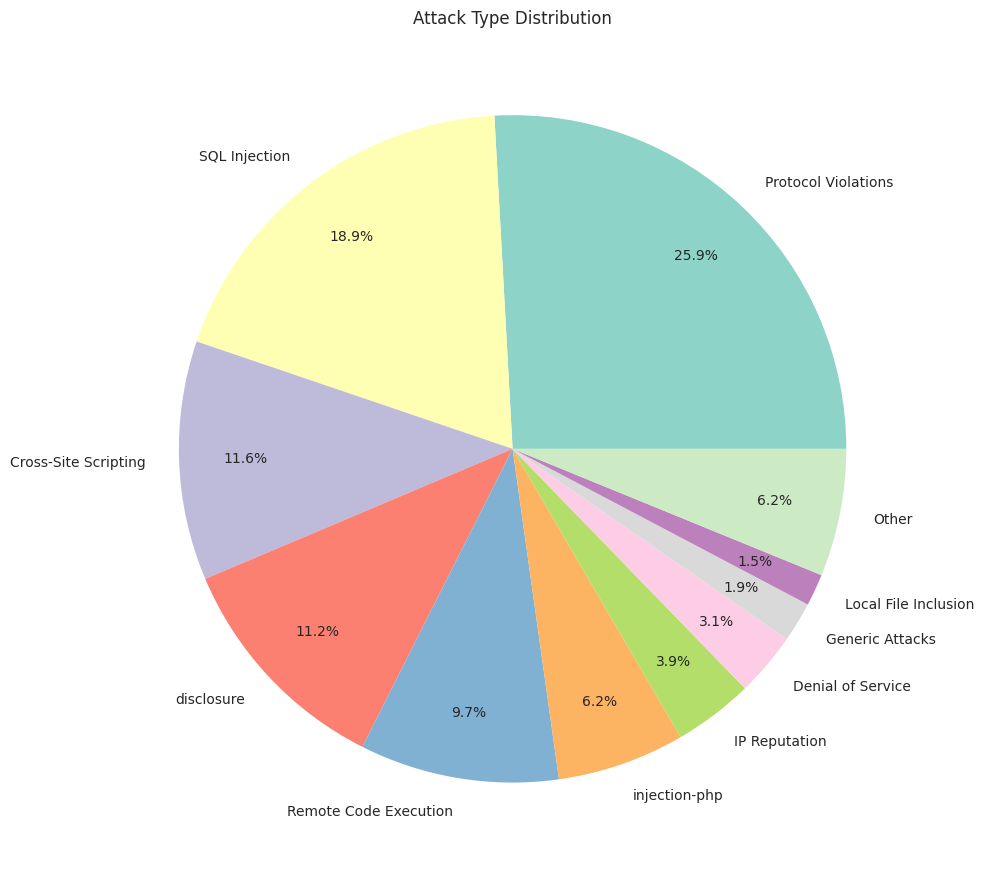

In [10]:
# Pie chart of attack types
display(Markdown("### Attack Type Distribution (Pie Chart)"))
fig = viz.plot_attack_type_pie(attack_dist)
plt.show()

In [11]:
# Coverage matrix: attack types vs paranoia levels
display(Markdown("### Attack Coverage by Paranoia Level (Matrix)"))
coverage_matrix = analyzer.attacks.get_coverage_matrix()
display(coverage_matrix)

### Attack Coverage by Paranoia Level (Matrix)

,Attack Type,PL1,PL2,PL3,PL4,Total
6,Protocol Violations,45,10,5,5,67
15,SQL Injection,16,24,7,2,49
14,Cross-Site Scripting,24,6,0,0,30
17,Disclosure,27,1,0,0,29
11,Remote Code Execution,17,5,3,0,25
12,Injection Php,11,1,4,0,16
1,IP Reputation,6,0,0,0,10
2,Denial of Service,2,1,0,0,8
0,Generic Attacks,1,0,0,0,5
9,Local File Inclusion,4,0,0,0,4


### Attack Coverage Heatmap

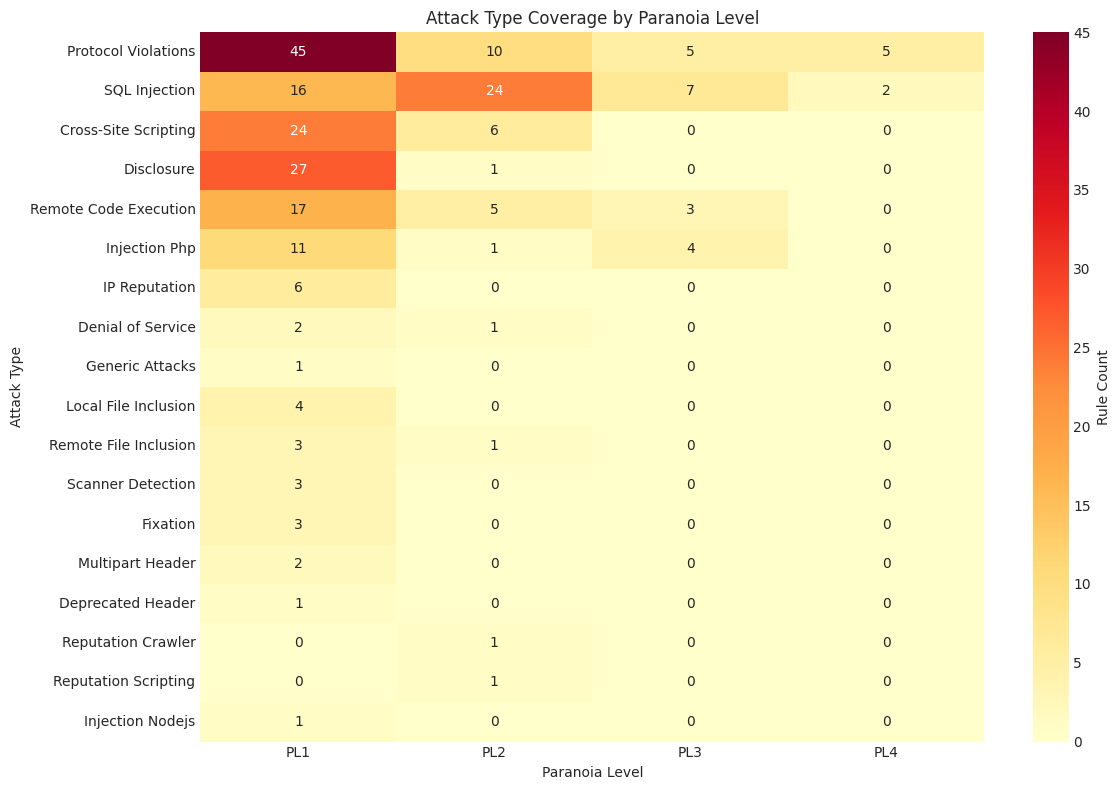

In [12]:
# Heatmap visualization
display(Markdown("### Attack Coverage Heatmap"))
if len(coverage_matrix) > 0:
    fig = viz.plot_attack_coverage_heatmap(coverage_matrix)
    plt.show()
else:
    print("No attack type data available for heatmap.")

## 6. Anomaly Score Analysis

Understanding how severity levels contribute to anomaly scores and threshold impacts.

Default CRS scores:
- CRITICAL: 5 points
- ERROR: 4 points
- WARNING: 3 points
- NOTICE: 2 points

In [13]:
# Anomaly score profile
display(Markdown("### Anomaly Score Profile"))
profile = analyzer.anomaly.get_score_profile()
for severity, data in profile.items():
    print(f"{severity}:")
    print(f"  Rules: {data['rule_count']}")
    print(f"  Base score: {data['base_score']}")
    print(f"  Max potential score: {data['max_potential_score']}")

### Anomaly Score Profile

NOTICE:
  Rules: 16
  Base score: 2
  Max potential score: 32
  Rules: 24
  Base score: 3
  Max potential score: 72
CRITICAL:
  Rules: 203
  Base score: 5
  Max potential score: 1015
ERROR:
  Rules: 12
  Base score: 4
  Max potential score: 48
EMERGENCY:
  Rules: 1
  Base score: 0
  Max potential score: 0
ALERT:
  Rules: 1
  Base score: 0
  Max potential score: 0


In [14]:
# Threshold impact analysis
display(Markdown("### Threshold Impact Analysis"))
display(Markdown("Minimum number of rule matches needed to reach each threshold:"))
threshold_df = analyzer.anomaly.get_threshold_analysis()
display(threshold_df)

### Threshold Impact Analysis

Minimum number of rule matches needed to reach each threshold:

,Threshold,Min CRITICAL,Min ERROR,Min WARNING,Min NOTICE
0,5,1,2,2,3
1,7,2,2,3,4
2,10,2,3,4,5
3,15,3,4,5,8
4,20,4,5,7,10
5,25,5,7,9,13


## 7. Rule Location Analysis

Distribution of rules by source location:
- **CRS Core**: Main CRS rules
- **CRS Exclusion**: Exclusion/exception rules
- **Custom Before**: Custom rules loaded before CRS
- **Custom After**: Custom rules loaded after CRS
- **App Specific**: Application-specific rules (WordPress, etc.)

In [15]:
# Get location statistics
loc_stats = analyzer.locations.get_stats_per_location()

display(Markdown("### Rules by Location"))
for loc, stats in loc_stats.items():
    if stats.rule_count > 0:
        print(f"{loc.value}: {stats.rule_count} rules in {stats.file_count} files")

### Rules by Location

setup: 4 rules in 1 files
app_specific: 23 rules in 1 files
crs_core: 592 rules in 26 files
crs_exclusion: 210 rules in 6 files


### Rules by Location (Chart)

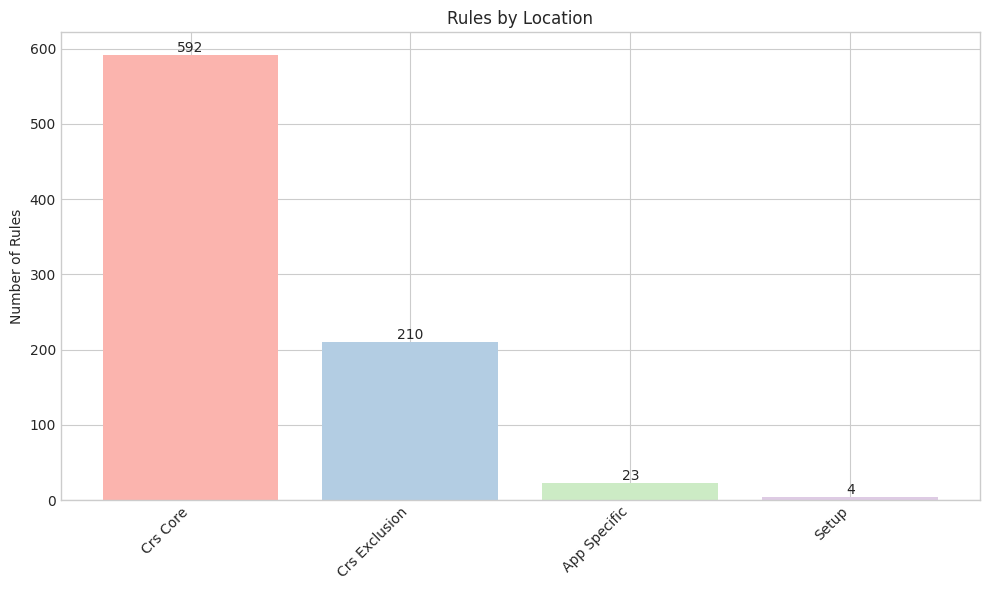

In [16]:
# Location bar chart
display(Markdown("### Rules by Location (Chart)"))
fig = viz.plot_location_bar(loc_stats)
plt.show()

## 8. Processing Phase Distribution

ModSecurity processes requests in phases:
- **Phase 1**: Request Headers
- **Phase 2**: Request Body
- **Phase 3**: Response Headers
- **Phase 4**: Response Body
- **Phase 5**: Logging

In [17]:
# Get phase statistics
phase_stats = analyzer.phases.get_stats_per_phase()

display(Markdown("### Phase Distribution Table"))
df_phases = analyzer.phases.get_dataframe()
display(df_phases)

### Phase Distribution Table

,Phase,Name,Rules,CRITICAL,ERROR,WARNING,NOTICE
0,1,Request Headers,158,15,0,0,0
1,2,Request Body,406,172,0,24,16
2,3,Response Headers,25,0,1,0,0
3,4,Response Body,57,16,11,0,0
4,5,Logging,16,0,0,0,0


### Phase Distribution (Chart)

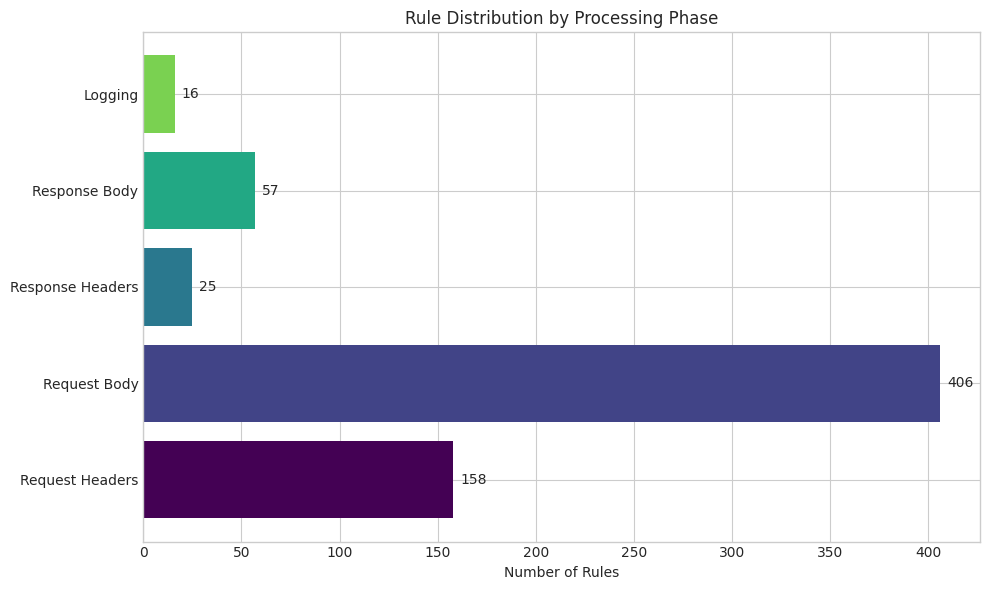

In [18]:
# Phase distribution chart
display(Markdown("### Phase Distribution (Chart)"))
fig = viz.plot_phase_distribution(phase_stats)
plt.show()

## 9. Severity Distribution

In [19]:
from collections import Counter

# Count severities
severity_counts = Counter()
for rule in analyzer.rules:
    if rule.severity:
        severity_counts[rule.severity] += 1

display(Markdown("### Severity Distribution"))
for severity, count in sorted(severity_counts.items()):
    print(f"  {severity}: {count} rules")

### Severity Distribution

  ALERT: 1 rules
  CRITICAL: 203 rules
  EMERGENCY: 1 rules
  ERROR: 12 rules
  NOTICE: 16 rules


### Severity Distribution (Donut Chart)

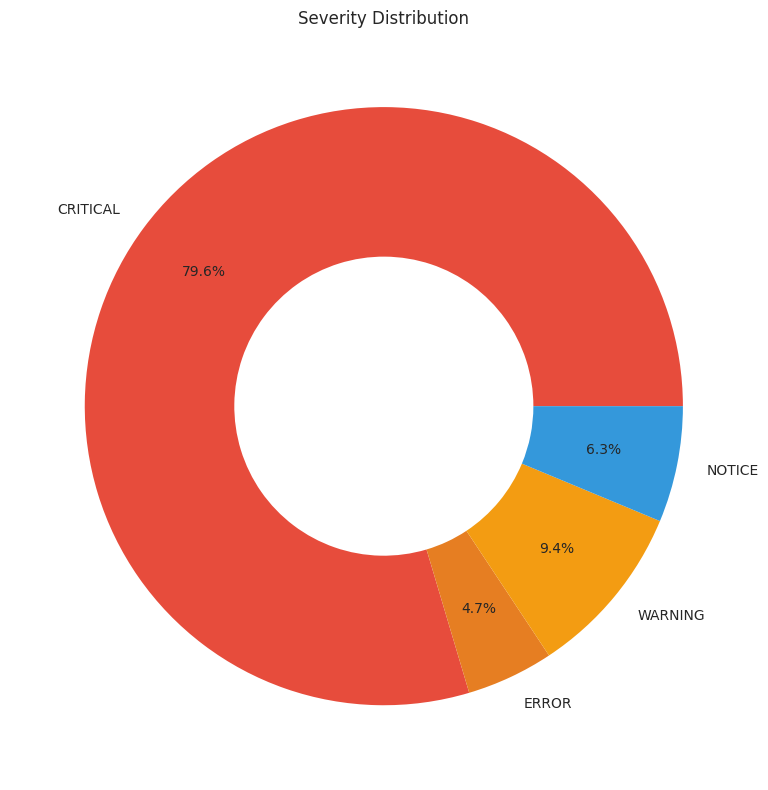

In [20]:
# Severity donut chart
display(Markdown("### Severity Distribution (Donut Chart)"))
fig = viz.plot_severity_donut(dict(severity_counts))
plt.show()

## 10. Detailed Rule Exploration

Interactive exploration of specific rules.

In [21]:
# Sample rules by attack type
display(Markdown("### Sample Rules by Attack Type"))

attack_stats = analyzer.attacks.get_stats_per_type()
for attack_type, stats in list(attack_stats.items())[:5]:  # Top 5 attack types
    print(f"\n{stats.display_name} (sample rule IDs): {stats.sample_rule_ids}")

### Sample Rules by Attack Type


Generic Attacks (sample rule IDs): [9005100, 905100, 905110, 911100, 949110]

IP Reputation (sample rule IDs): [910000, 910100, 910120, 910140, 910150]

Denial of Service (sample rule IDs): [912120, 912130, 912140, 912150, 912160]

Scanner Detection (sample rule IDs): [913100, 913110, 913120]

Reputation Scripting (sample rule IDs): [913101]


In [22]:
# List files parsed
display(Markdown("### Files Parsed"))
for i, f in enumerate(analyzer.files[:20], 1):  # First 20 files
    print(f"{i}. {f}")
if len(analyzer.files) > 20:
    print(f"... and {len(analyzer.files) - 20} more files")

### Files Parsed

1. /home/lucas/reforge/WAF-GUARD/experiments/config/modsecurity/setup.conf
2. /home/lucas/reforge/WAF-GUARD/experiments/config/modsecurity/crs-setup.conf
3. /home/lucas/reforge/WAF-GUARD/experiments/config/modsecurity/custom/crs/before-crs.conf
4. /home/lucas/reforge/WAF-GUARD/experiments/config/modsecurity/apps/wordpress/wordpress-hardening-before.conf
5. /home/lucas/reforge/WAF-GUARD/experiments/config/modsecurity/custom/apps/wordpress/wordpress-before.conf
6. /home/lucas/reforge/WAF-GUARD/experiments/config/modsecurity/crs_rules/REQUEST-901-INITIALIZATION.conf
7. /home/lucas/reforge/WAF-GUARD/experiments/config/modsecurity/crs_rules/REQUEST-903.9001-DRUPAL-EXCLUSION-RULES.conf
8. /home/lucas/reforge/WAF-GUARD/experiments/config/modsecurity/crs_rules/REQUEST-903.9002-WORDPRESS-EXCLUSION-RULES.conf
9. /home/lucas/reforge/WAF-GUARD/experiments/config/modsecurity/crs_rules/REQUEST-903.9003-NEXTCLOUD-EXCLUSION-RULES.conf
10. /home/lucas/reforge/WAF-GUARD/experiments/config/modsecurity/cr

## 11. Export Analysis Results

In [23]:
import json
from datetime import datetime

# Prepare export data
export_data = {
    "analysis_date": datetime.now().isoformat(),
    "config_file": CONFIG_PATH,
    "summary": analyzer.summary(),
    "paranoia_stats": {
        str(k): {
            "new_rules": v.new_rules_at_level,
            "cumulative_rules": v.cumulative_rules,
            "by_severity": v.rules_by_severity,
            "by_attack_type": v.rules_by_attack_type,
        }
        for k, v in pl_stats.items()
    },
    "attack_distribution": attack_dist,
    "phase_distribution": analyzer.phases.get_distribution(),
    "location_distribution": analyzer.locations.get_distribution(),
}

# Save to JSON
output_file = "crs_analysis_results.json"
with open(output_file, "w") as f:
    json.dump(export_data, f, indent=2, default=str)

print(f"Analysis exported to {output_file}")

Analysis exported to crs_analysis_results.json


---

## Summary

This analysis provides insights into:

1. **Paranoia Levels**: How rule coverage scales with sensitivity settings
2. **Attack Coverage**: Which attack types have the most rules
3. **Anomaly Scoring**: How thresholds affect blocking behavior
4. **Rule Sources**: Distribution between core CRS and custom rules
5. **Processing Phases**: When rules are evaluated during request processing

Use this data to:
- Choose appropriate paranoia levels for your environment
- Identify gaps in attack coverage
- Tune anomaly thresholds
- Understand the impact of custom rules